# Grafica temporal de las concentraciones de PM2.5


In [24]:
# Dar acceso a los archivos de Drive:
from google.colab import drive
drive.mount("/gdrive")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# Instalar las librerías que no se encuentran en el sistema
!pip install wrf-python # instalar wrf-python
!pip install pyproj==1.9.6
!apt-get -qq install libgeos-dev
!pip install -qq https://github.com/matplotlib/basemap/archive/master.zip # Instalar matplotlib



## Cargar los datos de los archivos NetCDF y librerias necesarias

In [20]:
# Llarmar las librerías para ser usadas en el código
!pip install netCDF4
from netCDF4 import Dataset
import numpy
import pandas
!pip install --upgrade matplotlib
import matplotlib.pyplot
from datetime import datetime

# Llamamos el archivo netCDF wrfout_d04...

datos = Dataset("/gdrive/My Drive/METEOROLOGIA/Taller_WRF/data/wrfout_d04_2025-03-18.nc")

In [6]:
# Llamar el archivo de excel y la hoja donde están los datos de ubicación de las estaciones de monitoreo
Estaciones = pandas.read_excel('/gdrive/My Drive/METEOROLOGIA/Taller_WRF/data/EstacionesBogota.xlsx', sheet_name='Ubic_Estaciones', index_col=False, header=0)
UBI_ESTACIONES = Estaciones.set_index('ESTACIONES')
print(UBI_ESTACIONES)

            NUMERO   LATITUD   LONGITUD  XLAT  XLONG
ESTACIONES                                          
Carvajal        CV  4.595616 -74.148583    28     29
CentAltoRen     CA  4.658467 -74.083966    35     37
Guaymaral       GU  4.783756 -74.044183    49     41
Kennedy         KE  4.621667 -74.161333    31     28
LasFerias       LF  4.690700 -74.082483    39     37
PuentAranda     PA  4.631767 -74.117483    32     33
SanCrist        SC  4.572553 -74.083813    26     37
Suba            SU  4.761247 -74.093461    47     36
Tunal           TU  4.576225 -74.130955    26     31
Usaquen         US  4.710350 -74.030417    41     43
Movil7ma        M7  4.645361 -74.061679    34     39
Fontibon        FO  4.670121 -74.141361    36     30
MinAmb          MA  4.625385 -74.067185    31     39


In [46]:
#******************************
# Modifique el nombre de la estación tal cual esta en la tabla de excel anterior dentro de las comillas.
# para poder capturar la celda de interes donde estaria ubicada la estación de monitoreo en el archivo netcdf
nombre_estacion = "Kennedy"
#*****************************

cel_lat = int(UBI_ESTACIONES.loc[nombre_estacion]['XLAT'])
cel_lon = int(UBI_ESTACIONES.loc[nombre_estacion]['XLONG'])

print(cel_lat, cel_lon)

31 28


# Gráfica Temporal de la Temperatura a 2m de altura

In [21]:
# Primero se hace un arreglo y lista de las fechas ya modificadas con horario local.
# el arreglo se llama Fechas

from datetime import datetime
import pandas

# Función para lear las fechas UTC y pasarlas a horario local.
def fechas_wrffile(wrf_file):
  datos_fechas = wrf_file.variables['Times'][:,:]
  fechas_limpias = []
  for raw in datos_fechas:
      fecha_str = b''.join(raw).decode('utf-8').replace('_', ' ')
      fecha = datetime.strptime(fecha_str, "%Y-%m-%d %H:%M:%S")
      fechas_limpias.append(fecha)
  fechas_locales = pandas.to_datetime(fechas_limpias) - pandas.Timedelta(hours=5)
  return fechas_locales

Fechas = fechas_wrffile(datos)

print('Primera y última fecha del archivo hora Bogotá:')
print(Fechas[0], '--', Fechas[-1])

Primera y última fecha del archivo hora Bogotá:
2025-03-17 19:00:00 -- 2025-03-22 19:00:00


In [18]:
# Crear un arreglo con las temperaturas del archivo netcdf de acuerdo a las coordenadas
# de ubicación de la estación con respecto al netcdf.

T2m = datos.variables['T2'][0:121,cel_lat, cel_lon] - 273.15

# Crear un data frame con los datos de las fechas y las temperaturas.
df_simulaciones = pandas.DataFrame.from_records({"T_(C)": T2m}, index=Fechas[0:816])
print(df_simulaciones)


                         T_(C)
2025-03-17 19:00:00  24.211450
2025-03-17 20:00:00  24.976251
2025-03-17 21:00:00  24.373621
2025-03-17 22:00:00  23.618219
2025-03-17 23:00:00  22.812982
...                        ...
2025-03-22 15:00:00  30.101556
2025-03-22 16:00:00  30.055597
2025-03-22 17:00:00  28.806696
2025-03-22 18:00:00  25.551508
2025-03-22 19:00:00  25.670801

[121 rows x 1 columns]


# Descarga de datos de la RMCAB

Descarga de datos de la RMCAB de la estación seleccionada en http://rmcab.ambientebogota.gov.co/Report/stationreport y suba el archivo excel en el drive para poder acceder a los datos.

** Recuerde que los datos de descarga deben coincidir con las fechas de comparación del archivo netcdf.


In [78]:
# Llamar el archivo de excel con los datos descargado.
import pandas as pd

# Leer archivo Excel sin asumir encabezado
archivo_path = "/gdrive/My Drive/METEOROLOGIA/Taller_WRF/data/Kennedy.xlsx"
df_raw = pd.read_excel(archivo_path, header=None)

# Extraer los encabezados correctos (fila 3 tiene los nombres de las variables)
column_names = df_raw.iloc[3].tolist()
column_names[0] = 'date'

# Extraer solo las filas con datos válidos (y quitar las últimas 11)
df_clean = df_raw.iloc[5:-11].copy()
df_clean.columns = column_names
df_clean.replace('----', pd.NA, inplace=True)

# Asegurar que 'date' es texto para manipularlo
df_clean['date'] = df_clean['date'].astype(str)

# Separar fecha y hora
fecha_hora = df_clean['date'].str.extract(r'(?P<fecha>\d{2}-\d{2}-\d{4})[ T_](?P<hora>\d{2})')

# Corregir fechas con hora 24
hora = fecha_hora['hora']
fecha = pd.to_datetime(fecha_hora['fecha'], format='%d-%m-%Y', errors='coerce')
hora_corr = hora.replace('24', '00')
fecha_corr = fecha + pd.to_timedelta(hora.eq('24').astype(int), unit='D')

# Crear nueva columna de fechas corregidas
df_clean['date'] = pd.to_datetime(
    fecha_corr.dt.strftime('%Y-%m-%d') + ' ' + hora_corr + ':00',
    format='%Y-%m-%d %H:%M'
)

# Ahora sí, establecer 'date' como índice
df_observaciones = df_clean.set_index('date')

# Obtener fechas inicial y final del DataFrame de simulaciones
fecha_ini = df_simulaciones.index[0]
fecha_fin = df_simulaciones.index[-1]

# Filtrar df_observaciones dentro de ese rango
df_observaciones = df_observaciones.loc[fecha_ini:fecha_fin]

print(df_observaciones.head())


                     PM10 PM2.5    CO   NO   NO2   NOX  SO2 Vel Viento  \
date                                                                     
2025-03-17 19:00:00  11.2   5.9  0.71    3  17.4  20.4  1.1        1.6   
2025-03-17 20:00:00  14.3   8.3  0.88  2.2  24.9  27.1  1.1          1   
2025-03-17 21:00:00    17   6.2  0.77  2.5  25.7  28.3    1        0.6   
2025-03-17 22:00:00  26.7   5.5  0.81  4.3    26  30.3  1.2        0.6   
2025-03-17 23:00:00  31.1   8.1  0.49  2.3  18.6  20.9    1        1.7   

                    Dir Viento Precipitacion    HR PM2.5 Flow Rad Solar   CO2  \
date                                                                            
2025-03-17 19:00:00        299             0  85.7       <NA>         0  <NA>   
2025-03-17 20:00:00        344             0  87.5       <NA>         0  <NA>   
2025-03-17 21:00:00        341             0  86.7       <NA>         0  <NA>   
2025-03-17 22:00:00        333             0  86.1       <NA>         0  <NA

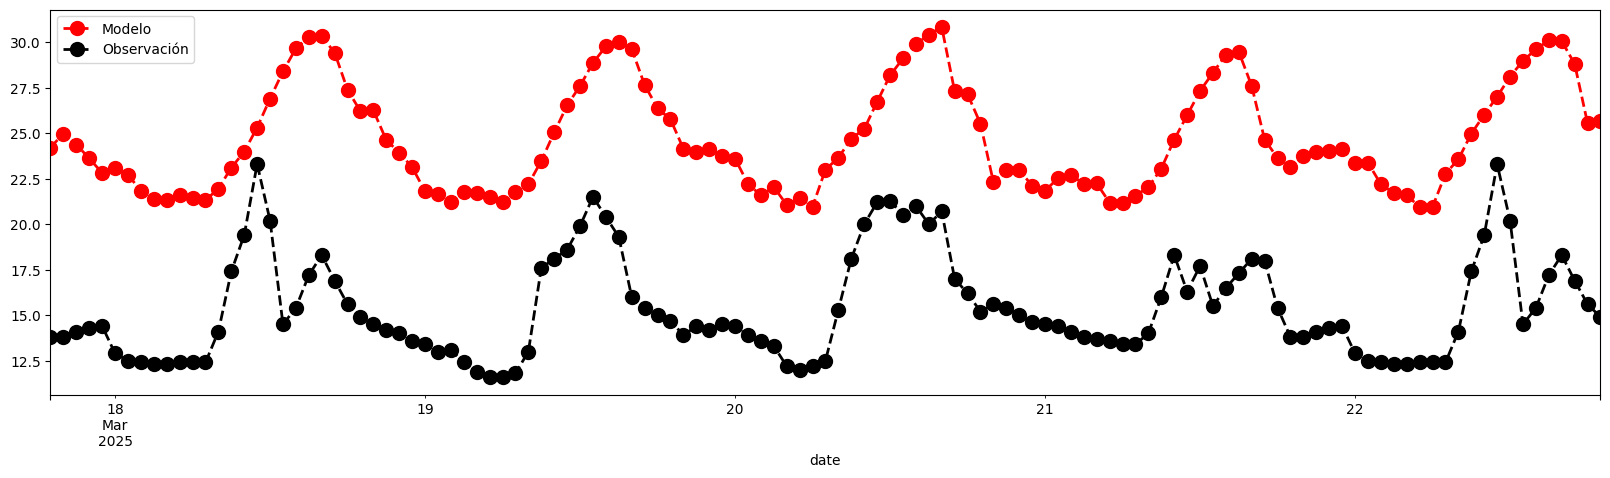

In [79]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20,5))

# Asegúrate de que los índices de ambos DataFrames son de tipo datetime
df_observaciones.index = pd.to_datetime(df_observaciones.index)
df_simulaciones.index = pd.to_datetime(df_simulaciones.index)

df_simulaciones['T_(C)'].plot(ax=ax, kind='line', style='--o', markersize=10, color='r', linewidth=2, label='Modelo')

# Convertir la columna 'Temperatura' a numérico (forzando errores a NaN si hay texto oculto)
df_observaciones['Temperatura'] = pd.to_numeric(df_observaciones['Temperatura'], errors='coerce')

df_observaciones['Temperatura'].plot(ax=ax, kind='line', style='--o', markersize=10, color='k', linewidth=2, label='Observación')
ax.legend().set_visible(True)


# Gráfica Temporal Dirección y Velocidad del Viento

In [81]:
import numpy as np

U = (datos.variables['U10'][:,cel_lat,cel_lon])
V = (datos.variables['V10'][:,cel_lat,cel_lon])

# Velocidad del viento (magnitud)
WS = np.sqrt(U**2 + V**2)

# Dirección del viento (en grados meteorológicos)
wind_dir_rad = np.arctan2(-U, -V)  # arctan2(y, x)
wind_dir_deg = np.degrees(wind_dir_rad)
# Asegurar que esté en el rango 0–360
WD = (wind_dir_deg + 360) % 360


# Crear un data frame con los datos
df_simulaciones = pandas.DataFrame.from_records({"WS": WS, "WD": WD}, index=Fechas[0:816])
print(df_simulaciones)


                             WD        WS
2025-03-17 19:00:00  146.847778  0.495575
2025-03-17 20:00:00  142.844757  0.641403
2025-03-17 21:00:00   43.524929  1.158688
2025-03-17 22:00:00   56.762428  0.407597
2025-03-17 23:00:00  302.219238  0.121476
...                         ...       ...
2025-03-22 15:00:00  121.114273  5.521131
2025-03-22 16:00:00  127.333214  4.638535
2025-03-22 17:00:00  147.012863  5.242918
2025-03-22 18:00:00  147.309158  5.532646
2025-03-22 19:00:00  153.542343  4.346415

[121 rows x 2 columns]


# Dirección del Viento

<ipython-input-84-cfb945a2b53c>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_simulaciones['WD'].resample('H').mean().plot(ax=ax, kind='line', style='--o', markersize=10, color='r', linewidth=2, label='Model')
<ipython-input-84-cfb945a2b53c>:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_observaciones['Dir Viento'].resample('H').mean().plot(ax=ax, kind='line', style='--o', markersize=10, color='k', linewidth=2, label='Observaciones')


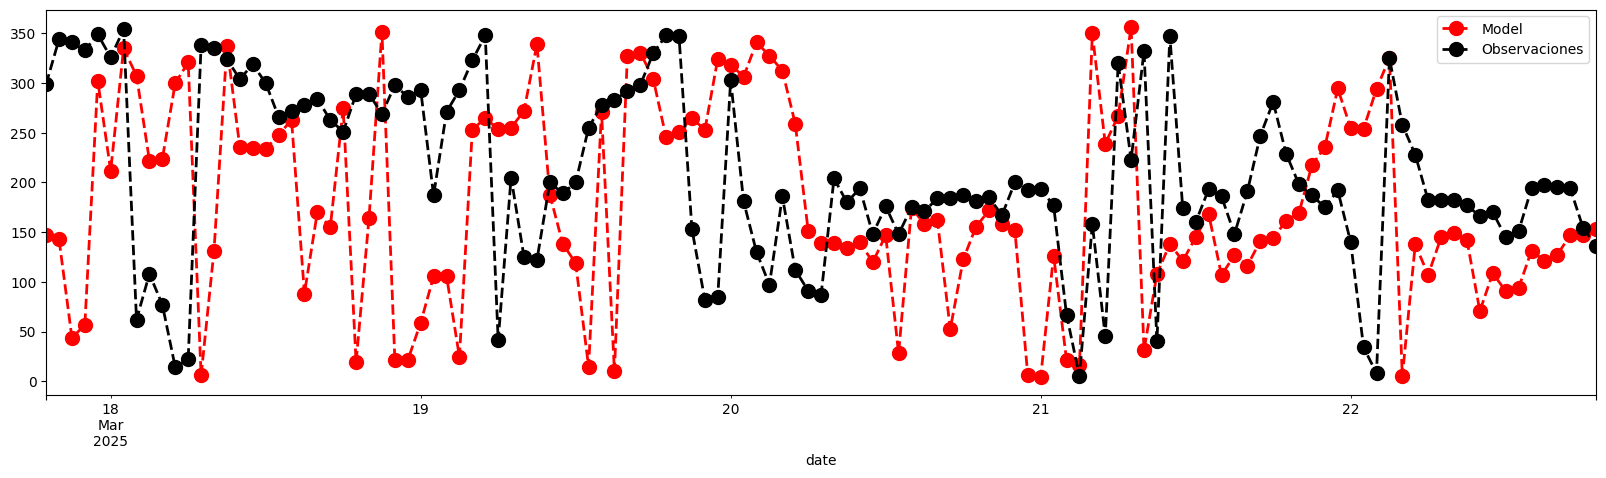

In [84]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20,5))

df_simulaciones['WD'].resample('H').mean().plot(ax=ax, kind='line', style='--o', markersize=10, color='r', linewidth=2, label='Model')

# Colocar el nombre de la variable
df_observaciones['Dir Viento'].resample('H').mean().plot(ax=ax, kind='line', style='--o', markersize=10, color='k', linewidth=2, label='Observaciones')
ax.legend().set_visible(True)

# Velocidad del Viento

<ipython-input-85-ae2e1d54369b>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_simulaciones['WS'].resample('H').mean().plot(ax=ax, kind='line', style='--o', markersize=10, color='r', linewidth=2, label='Model')
<ipython-input-85-ae2e1d54369b>:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_observaciones['Vel Viento'].resample('H').mean().plot(ax=ax, kind='line', style='--o', markersize=10, color='k', linewidth=2, label='Observaciones')


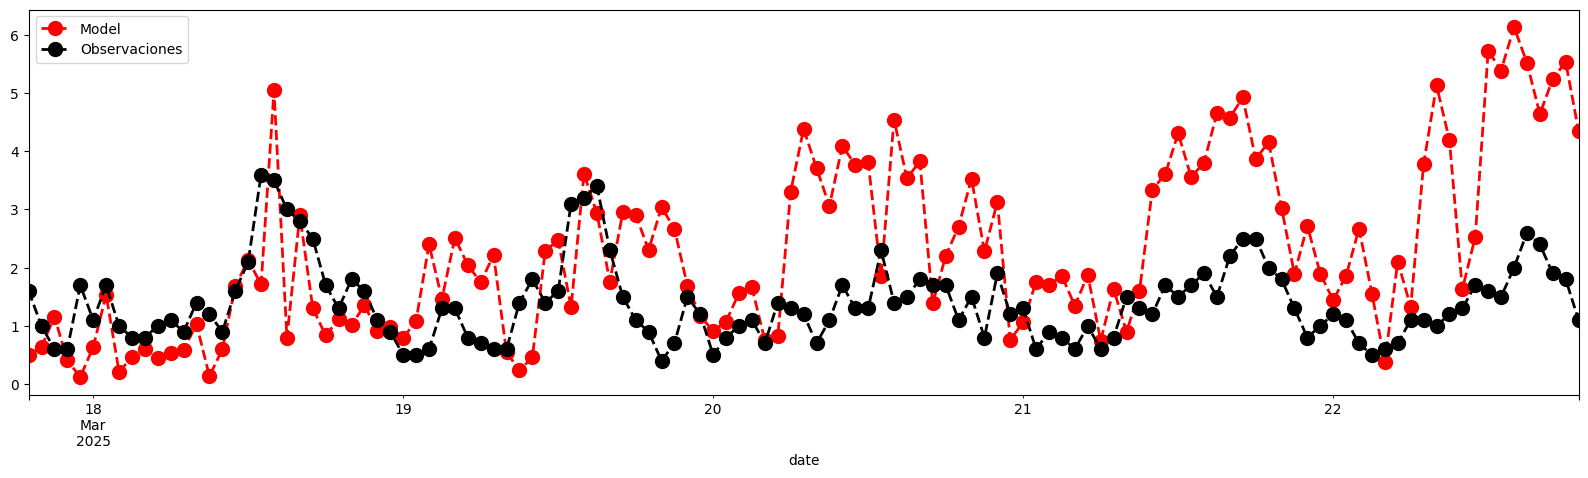

In [85]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20,5))

df_simulaciones['WS'].resample('H').mean().plot(ax=ax, kind='line', style='--o', markersize=10, color='r', linewidth=2, label='Model')

# Colocar el nombre de la variable
df_observaciones['Vel Viento'].resample('H').mean().plot(ax=ax, kind='line', style='--o', markersize=10, color='k', linewidth=2, label='Observaciones')
ax.legend().set_visible(True)